# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    #need to declare here and not when testing on an image: modellib.load_image_gt(dataset_val, inference_config, 
    #                      image_id) #, use_mini_mask=False)
    USE_MINI_MASK=False

    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

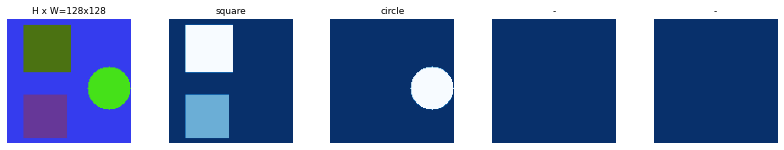

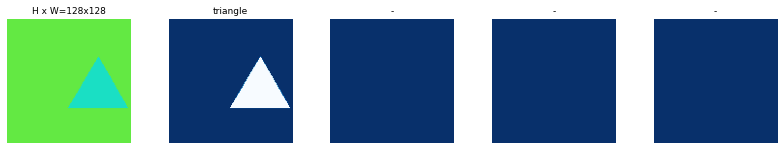

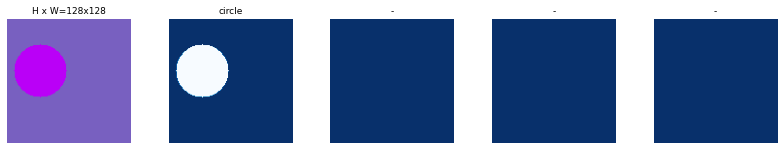

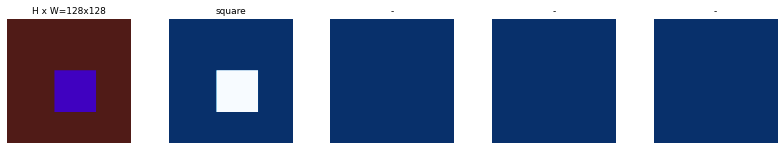

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\jente\OneDrive\Documenten\GitHub\Mask-RCNN\logs\shapes20220517T1231\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDist

C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\jente\AppData\Roaming\Python\Python36\

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 8.0000 - loss: 1.4310 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.3278 - mrcnn_mask_loss: 0.2595

C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


100/100 [==============================] - 175s 2s/step - batch: 49.5000 - size: 8.0000 - loss: 1.4310 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.3278 - mrcnn_mask_loss: 0.2595 - val_loss: 0.8554 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.4320 - val_mrcnn_class_loss: 0.1404 - val_mrcnn_bbox_loss: 0.1504 - val_mrcnn_mask_loss: 0.1186


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\jente\Mask2\Mask_RCNN\logs\shapes20220324T1346\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 2/2


C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/ROI/GatherV2_8_grad/Reshape_1:0", shape=(4092,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/ROI/GatherV2_8_grad/Reshape:0", shape=(4092, 4), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/ROI/GatherV2_8_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/ROI/GatherV2_9_grad/Reshape_1:0", shape=(4092,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/ROI/GatherV2

  1/100 [..............................] - ETA: 41:06 - batch: 0.0000e+00 - size: 8.0000 - loss: 1.8204 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.4759 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.1259

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  2/100 [..............................] - ETA: 3:19 - batch: 0.5000 - size: 8.0000 - loss: 1.7150 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.1085     

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  3/100 [..............................] - ETA: 2:51 - batch: 1.0000 - size: 8.0000 - loss: 1.6862 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4318 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.1118

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  4/100 [>.............................] - ETA: 2:41 - batch: 1.5000 - size: 8.0000 - loss: 1.7082 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.1075

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  5/100 [>.............................] - ETA: 2:34 - batch: 2.0000 - size: 8.0000 - loss: 1.7446 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1178

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  6/100 [>.............................] - ETA: 2:28 - batch: 2.5000 - size: 8.0000 - loss: 1.7134 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4524 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.1106

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  7/100 [=>............................] - ETA: 2:24 - batch: 3.0000 - size: 8.0000 - loss: 1.6674 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.1102

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  8/100 [=>............................] - ETA: 2:20 - batch: 3.5000 - size: 8.0000 - loss: 1.6713 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4280 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.1098

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  9/100 [=>............................] - ETA: 2:15 - batch: 4.0000 - size: 8.0000 - loss: 1.6615 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1069

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 10/100 [==>...........................] - ETA: 2:11 - batch: 4.5000 - size: 8.0000 - loss: 1.6511 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4303 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1032

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 11/100 [==>...........................] - ETA: 2:09 - batch: 5.0000 - size: 8.0000 - loss: 1.6061 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4205 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.0996

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 12/100 [==>...........................] - ETA: 2:05 - batch: 5.5000 - size: 8.0000 - loss: 1.6016 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4239 - mrcnn_class_loss: 0.1266 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.0970

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 13/100 [==>...........................] - ETA: 2:01 - batch: 6.0000 - size: 8.0000 - loss: 1.6145 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4262 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.0987

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 14/100 [===>..........................] - ETA: 1:58 - batch: 6.5000 - size: 8.0000 - loss: 1.5848 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4192 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.0972

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 15/100 [===>..........................] - ETA: 1:55 - batch: 7.0000 - size: 8.0000 - loss: 1.5588 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4139 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.0955

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 16/100 [===>..........................] - ETA: 1:53 - batch: 7.5000 - size: 8.0000 - loss: 1.5614 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4141 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.0973

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 17/100 [====>.........................] - ETA: 1:51 - batch: 8.0000 - size: 8.0000 - loss: 1.5607 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4188 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.0957

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 18/100 [====>.........................] - ETA: 1:48 - batch: 8.5000 - size: 8.0000 - loss: 1.5544 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.0965

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 19/100 [====>.........................] - ETA: 1:47 - batch: 9.0000 - size: 8.0000 - loss: 1.5371 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4133 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.0949

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 20/100 [=====>........................] - ETA: 1:44 - batch: 9.5000 - size: 8.0000 - loss: 1.5301 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4150 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.0938

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 21/100 [=====>........................] - ETA: 1:42 - batch: 10.0000 - size: 8.0000 - loss: 1.5248 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4123 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.0940

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 22/100 [=====>........................] - ETA: 1:41 - batch: 10.5000 - size: 8.0000 - loss: 1.5289 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4169 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.0946

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 23/100 [=====>........................] - ETA: 1:39 - batch: 11.0000 - size: 8.0000 - loss: 1.5239 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4151 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.0939

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 24/100 [======>.......................] - ETA: 1:37 - batch: 11.5000 - size: 8.0000 - loss: 1.4959 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.0920

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 25/100 [======>.......................] - ETA: 1:35 - batch: 12.0000 - size: 8.0000 - loss: 1.5192 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.0904

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 26/100 [======>.......................] - ETA: 1:34 - batch: 12.5000 - size: 8.0000 - loss: 1.4991 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.0890

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 27/100 [=======>......................] - ETA: 1:32 - batch: 13.0000 - size: 8.0000 - loss: 1.4893 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4217 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.0885

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 28/100 [=======>......................] - ETA: 1:30 - batch: 13.5000 - size: 8.0000 - loss: 1.4838 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.0881

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 29/100 [=======>......................] - ETA: 1:29 - batch: 14.0000 - size: 8.0000 - loss: 1.4953 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4273 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.0877

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 30/100 [========>.....................] - ETA: 1:28 - batch: 14.5000 - size: 8.0000 - loss: 1.4975 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4279 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.0874

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 31/100 [========>.....................] - ETA: 1:26 - batch: 15.0000 - size: 8.0000 - loss: 1.4948 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.0866

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 32/100 [========>.....................] - ETA: 1:25 - batch: 15.5000 - size: 8.0000 - loss: 1.4936 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.0859

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 33/100 [========>.....................] - ETA: 1:23 - batch: 16.0000 - size: 8.0000 - loss: 1.4966 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4250 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.0868

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 34/100 [=========>....................] - ETA: 1:22 - batch: 16.5000 - size: 8.0000 - loss: 1.5037 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.0904

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 35/100 [=========>....................] - ETA: 1:21 - batch: 17.0000 - size: 8.0000 - loss: 1.5027 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.0896

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 36/100 [=========>....................] - ETA: 1:19 - batch: 17.5000 - size: 8.0000 - loss: 1.4932 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.0891

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 37/100 [==========>...................] - ETA: 1:18 - batch: 18.0000 - size: 8.0000 - loss: 1.4856 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4210 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.0882

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 38/100 [==========>...................] - ETA: 1:17 - batch: 18.5000 - size: 8.0000 - loss: 1.4845 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.0875

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 39/100 [==========>...................] - ETA: 1:15 - batch: 19.0000 - size: 8.0000 - loss: 1.4787 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4200 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.0885

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 40/100 [===========>..................] - ETA: 1:14 - batch: 19.5000 - size: 8.0000 - loss: 1.4723 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4177 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.0884

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 41/100 [===========>..................] - ETA: 1:12 - batch: 20.0000 - size: 8.0000 - loss: 1.4702 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.0877

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 42/100 [===========>..................] - ETA: 1:11 - batch: 20.5000 - size: 8.0000 - loss: 1.4636 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4156 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.0878

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 43/100 [===========>..................] - ETA: 1:10 - batch: 21.0000 - size: 8.0000 - loss: 1.4635 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4163 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.0876

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 44/100 [============>.................] - ETA: 1:08 - batch: 21.5000 - size: 8.0000 - loss: 1.4731 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.0886

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 45/100 [============>.................] - ETA: 1:07 - batch: 22.0000 - size: 8.0000 - loss: 1.4775 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4183 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.0898

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 46/100 [============>.................] - ETA: 1:06 - batch: 22.5000 - size: 8.0000 - loss: 1.4689 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.0888

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 47/100 [=============>................] - ETA: 1:04 - batch: 23.0000 - size: 8.0000 - loss: 1.4664 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4195 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.0879

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 48/100 [=============>................] - ETA: 1:03 - batch: 23.5000 - size: 8.0000 - loss: 1.4666 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.0880

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 49/100 [=============>................] - ETA: 1:02 - batch: 24.0000 - size: 8.0000 - loss: 1.4597 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4188 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.0882

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 50/100 [==============>...............] - ETA: 1:01 - batch: 24.5000 - size: 8.0000 - loss: 1.4588 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4184 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.0884

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 51/100 [==============>...............] - ETA: 59s - batch: 25.0000 - size: 8.0000 - loss: 1.4520 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.0878 

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 52/100 [==============>...............] - ETA: 58s - batch: 25.5000 - size: 8.0000 - loss: 1.4447 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.0875

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 53/100 [==============>...............] - ETA: 57s - batch: 26.0000 - size: 8.0000 - loss: 1.4457 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.0875

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 54/100 [===============>..............] - ETA: 56s - batch: 26.5000 - size: 8.0000 - loss: 1.4458 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4131 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.0874

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 55/100 [===============>..............] - ETA: 54s - batch: 27.0000 - size: 8.0000 - loss: 1.4445 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4140 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.0871

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 56/100 [===============>..............] - ETA: 53s - batch: 27.5000 - size: 8.0000 - loss: 1.4438 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4139 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.0871

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 57/100 [================>.............] - ETA: 52s - batch: 28.0000 - size: 8.0000 - loss: 1.4411 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.0872

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 58/100 [================>.............] - ETA: 51s - batch: 28.5000 - size: 8.0000 - loss: 1.4331 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4112 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.0869

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 59/100 [================>.............] - ETA: 49s - batch: 29.0000 - size: 8.0000 - loss: 1.4278 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4107 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.0864

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 60/100 [=================>............] - ETA: 48s - batch: 29.5000 - size: 8.0000 - loss: 1.4282 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4102 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.0865

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 61/100 [=================>............] - ETA: 47s - batch: 30.0000 - size: 8.0000 - loss: 1.4252 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.0861

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 62/100 [=================>............] - ETA: 46s - batch: 30.5000 - size: 8.0000 - loss: 1.4184 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.0857

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 63/100 [=================>............] - ETA: 44s - batch: 31.0000 - size: 8.0000 - loss: 1.4144 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.0852

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 64/100 [==================>...........] - ETA: 43s - batch: 31.5000 - size: 8.0000 - loss: 1.4145 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.0852

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 65/100 [==================>...........] - ETA: 42s - batch: 32.0000 - size: 8.0000 - loss: 1.4143 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.0848

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 66/100 [==================>...........] - ETA: 41s - batch: 32.5000 - size: 8.0000 - loss: 1.4139 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.0849

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 67/100 [===================>..........] - ETA: 39s - batch: 33.0000 - size: 8.0000 - loss: 1.4051 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.0843

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 68/100 [===================>..........] - ETA: 38s - batch: 33.5000 - size: 8.0000 - loss: 1.4018 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.0841

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 69/100 [===================>..........] - ETA: 37s - batch: 34.0000 - size: 8.0000 - loss: 1.3993 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.0836

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 70/100 [====================>.........] - ETA: 36s - batch: 34.5000 - size: 8.0000 - loss: 1.3972 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4066 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.0833

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 71/100 [====================>.........] - ETA: 34s - batch: 35.0000 - size: 8.0000 - loss: 1.3931 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.0831

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 72/100 [====================>.........] - ETA: 33s - batch: 35.5000 - size: 8.0000 - loss: 1.3940 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.0832

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 73/100 [====================>.........] - ETA: 32s - batch: 36.0000 - size: 8.0000 - loss: 1.3909 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.0830

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 74/100 [=====================>........] - ETA: 31s - batch: 36.5000 - size: 8.0000 - loss: 1.3902 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.0826

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 75/100 [=====================>........] - ETA: 30s - batch: 37.0000 - size: 8.0000 - loss: 1.3928 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4085 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.0824

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 76/100 [=====================>........] - ETA: 28s - batch: 37.5000 - size: 8.0000 - loss: 1.3957 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.0837

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 77/100 [======================>.......] - ETA: 27s - batch: 38.0000 - size: 8.0000 - loss: 1.3905 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.0834

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 78/100 [======================>.......] - ETA: 26s - batch: 38.5000 - size: 8.0000 - loss: 1.3909 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.0836

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 79/100 [======================>.......] - ETA: 25s - batch: 39.0000 - size: 8.0000 - loss: 1.3869 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.0833

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 80/100 [=======================>......] - ETA: 24s - batch: 39.5000 - size: 8.0000 - loss: 1.3869 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.0843

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 81/100 [=======================>......] - ETA: 22s - batch: 40.0000 - size: 8.0000 - loss: 1.3848 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4051 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.0840

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 82/100 [=======================>......] - ETA: 21s - batch: 40.5000 - size: 8.0000 - loss: 1.3822 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.0837

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 83/100 [=======================>......] - ETA: 20s - batch: 41.0000 - size: 8.0000 - loss: 1.3800 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.0836

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 84/100 [========================>.....] - ETA: 19s - batch: 41.5000 - size: 8.0000 - loss: 1.3770 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.0834

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 85/100 [========================>.....] - ETA: 18s - batch: 42.0000 - size: 8.0000 - loss: 1.3784 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.0834

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 86/100 [========================>.....] - ETA: 16s - batch: 42.5000 - size: 8.0000 - loss: 1.3800 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4040 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.0834

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 87/100 [=========================>....] - ETA: 15s - batch: 43.0000 - size: 8.0000 - loss: 1.3809 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.0841

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 88/100 [=========================>....] - ETA: 14s - batch: 43.5000 - size: 8.0000 - loss: 1.3819 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.0848

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 89/100 [=========================>....] - ETA: 13s - batch: 44.0000 - size: 8.0000 - loss: 1.3818 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.0846

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 90/100 [==========================>...] - ETA: 12s - batch: 44.5000 - size: 8.0000 - loss: 1.3788 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.0844

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 91/100 [==========================>...] - ETA: 11s - batch: 45.0000 - size: 8.0000 - loss: 1.3761 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4025 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.0841

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 92/100 [==========================>...] - ETA: 10s - batch: 45.5000 - size: 8.0000 - loss: 1.3746 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4032 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.0837

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 93/100 [==========================>...] - ETA: 8s - batch: 46.0000 - size: 8.0000 - loss: 1.3752 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.0834 

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 94/100 [===========================>..] - ETA: 7s - batch: 46.5000 - size: 8.0000 - loss: 1.3757 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.0833

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 95/100 [===========================>..] - ETA: 6s - batch: 47.0000 - size: 8.0000 - loss: 1.3745 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.0834

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 96/100 [===========================>..] - ETA: 5s - batch: 47.5000 - size: 8.0000 - loss: 1.3715 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.0832

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 97/100 [============================>.] - ETA: 3s - batch: 48.0000 - size: 8.0000 - loss: 1.3672 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.0828

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 98/100 [============================>.] - ETA: 2s - batch: 48.5000 - size: 8.0000 - loss: 1.3662 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.0829

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 99/100 [============================>.] - ETA: 1s - batch: 49.0000 - size: 8.0000 - loss: 1.3641 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.0826

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 8.0000 - loss: 1.3616 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.0823

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\jente\anaconda3\envs\Mask\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

100/100 [==============================] - 161s 1s/step - batch: 49.5000 - size: 8.0000 - loss: 1.3616 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.0823 - val_loss: 1.5287 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.3984 - val_mrcnn_class_loss: 0.1088 - val_mrcnn_bbox_loss: 0.1104 - val_mrcnn_mask_loss: 0.1350


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [10]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  C:\Users\jente\OneDrive\Documenten\GitHub\Mask-RCNN\logs\shapes20220517T1231\mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:    9.00000  max:  185.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (2,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:   11.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


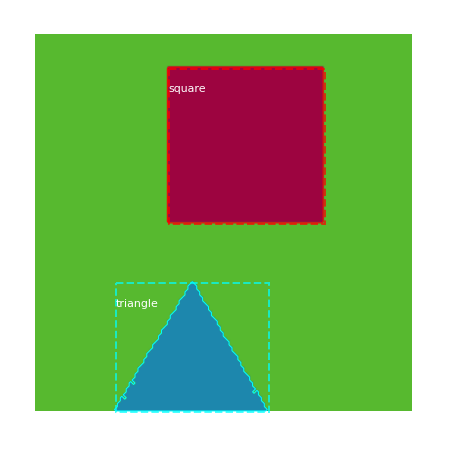

In [11]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id) #, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   19.00000  max:  230.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -84.90000  max:  113.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


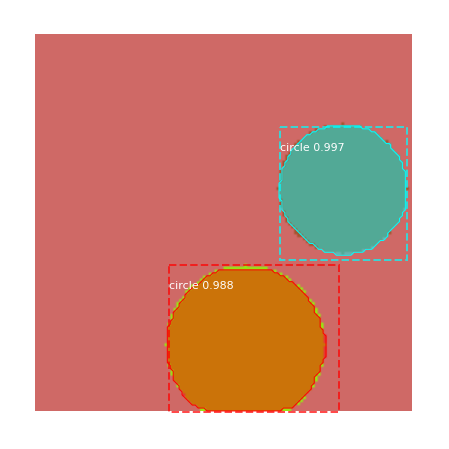

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id) #, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

C:\Users\jente\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


mAP:  0.9666666686534882
